# How to use 2D Funnel potential with OpenMM MD Framework

In this Notebook we will try to apply 2D funnel potential in OpenMM to test sampling efficiency of MD simulations.
You can use this potential for various testing purporses 

In [1]:
# if you copy and paste the code, remember to make appropiate imports
from simtk.unit import kelvin, picosecond, femtosecond, nanosecond, nanometer, amu, angstrom
import simtk.openmm as mm
import simtk.openmm.app as amm
import matplotlib.pyplot as plt
import numpy as np

### Definition of the 2D potential

In [2]:
"""Propagating 2D dynamics on the 2D funnel potential using OpenMM.
Currently, ana harmonic restraint on the z coordinate is put,
since OpenMM needs to work in 3D. This isn't really a big deal, except
that it affects the meaning of the temperature and kinetic energy. So
take the meaning of those numbers with a grain of salt.
Based on the gist of David de Sancho: 
https://gist.github.com/daviddesancho/94c2a32f12f897fb68536f723c783a0b#file-openmuller-py
"""

class TwoDFunnel(mm.CustomExternalForce):
    """OpenMM custom force for propagation on the 2D Funnel Potential. Also
    includes pure python evaluation of the potential energy surface so that
    you can do some plotting"""

    def __init__(self):
        # start with a harmonic restraint on the Z coordinate
        expression = '2*cos(2*sqrt(x^2+y^2)) - 8*exp(-(x^2+y^2)) + 0.2*((x/8)^2+(y/8)^2)^3 + 1000.0 * z^2'
        super(TwoDFunnel, self).__init__(expression)
    
    @classmethod
    def potential(cls, x, y):
        "Compute the potential at a given point x,y"
        value = 2*np.cos(2*np.sqrt(x**2+y**2)) - 8*np.exp(-(x**2+y**2)) + 0.2*((x/8)**2+(y/8)**2)**3
        return value

    @classmethod
    def plot(cls, ax=None, minx=-11.0, maxx=11.0, miny=-11.0, maxy=11.0, **kwargs):
        "Plot the 2D funnel potential"
        grid_res = 1000
        grid_width = max(maxx-minx, maxy-miny) / grid_res
        ax = kwargs.pop('ax', None)
        xx, yy = np.mgrid[minx : maxx : grid_width, miny : maxy : grid_width]
        V = cls.potential(xx, yy)
        # clip off any values greater than grid_res, since they mess up
        # the color scheme
        if ax is None:
            # it requires plt object from matplotlib so import accordingly 
            ax = plt
        f = ax.contourf(xx, yy, V, 8, nchunk=3,**kwargs)
        plt.colorbar(f)




### Define the parameters and system

In [3]:
# each particle is totally independent, propagating under the same potential
nParticles = 10
mass = 1000 * amu
temperature = 750 * kelvin
friction = 100 / picosecond
timestep = 10.0 * femtosecond


# Choose starting conformations uniform on the grid so that it's r=10 away from the center of the 2D potential
r = np.array([10] * nParticles)
startingPositions = (np.random.rand(nParticles, 3) * np.array([20, 20, 0])) + np.array([-10, -10, 0])
while True:
    mask = np.isclose(np.sum(startingPositions**2, axis=1), r**2)
    if np.all(mask):
        break
    else:
        mask = mask.reshape(nParticles, 1)
        # save candidates that meet our criteria
        prev_startingPositions = startingPositions
        startingPositions = (np.random.rand(nParticles, 3) * np.array([20, 20, 0])) + np.array([-10, -10, 0])
        startingPositions = startingPositions * ~mask + prev_startingPositions * mask


# define 2D funnel potential
twodfunnelforce = TwoDFunnel()

system = mm.System()
topology = mm.app.topology.Topology()
chain = topology.addChain("A")
res = topology.addResidue("1", chain)
# We add mass of the particle later, Hydrogen is used only as a technical trick here
# The hydrogen does not interact with other particles
# Because nonbonded forces are not added to the system
element = amm.element.Element.getBySymbol('H')
twodfunnelforce = TwoDFunnel()

for i in range(nParticles):
    # Add particles of mass `mass` to the simulation
    ind = system.addParticle(mass)
    # Add the particle to the defined 2D potential
    twodfunnelforce.addParticle(ind, [])
    # Create topology for the molecules
    topology.addAtom('X'+str(i), element, res, ind)
system.addForce(twodfunnelforce)

0

### Define OpenMM objects

In [4]:
integrator = mm.LangevinMiddleIntegrator(temperature, friction, timestep)
simulation = amm.Simulation(topology, system, integrator)
simulation.context.setPositions(startingPositions)
simulation.context.setVelocitiesToTemperature(temperature)
context = simulation.context

### Start simulation and plot every N steps a black dot for every position of every particle

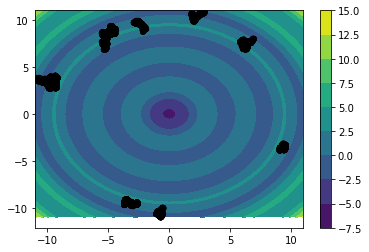

In [5]:
TwoDFunnel.plot(ax=plt.gca())

for i in range(1000):
    x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)
    plt.scatter(x[:,0], x[:,1], edgecolor='none', facecolor='k')
    integrator.step(250)
plt.show()